In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from talib import RSI, BBANDS,WILLR,MACD
import re
import talib as ta
from sklearn.model_selection import train_test_split
from sklearn import svm 
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from sklearn.model_selection import GridSearchCV
import random
from sklearn import svm 

# Importing

In [9]:
data=pd.read_csv('india.csv')
#data.set_index('Date',inplace=True)

# Cleaning Data

In [10]:
for data in [data]:
    for columns in data.columns :
        data[columns] = data[columns].apply(lambda x : re.sub(r'[^0-9.]+','',x))

In [11]:
data = data.iloc[::-1]
data

,Date,Price,Open,High,Low,Vol.,Change %
2498,132010,5178.90,5157.55,5212.70,5147.95,179.38,0.43
2497,142010,5093.50,5180.55,5192.75,5070.95,144.38,1.65
2496,172010,5059.90,5093.90,5094.55,4966.25,169.31,0.66
2495,182010,5066.20,5059.55,5105.20,5024.25,137.03,0.12
2494,192010,4919.65,5065.10,5065.10,4908.15,212.95,2.89
...,...,...,...,...,...,...,...
4,082020,10167.45,10326.75,10328.50,10120.25,936.49,0.25
3,092020,10046.65,10181.15,10291.15,10021.45,754.22,1.19
2,102020,10116.15,10072.60,10148.75,10036.85,632.38,0.69
1,112020,9902.00,10094.10,10112.05,9885.05,715.45,2.12


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 2498 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2499 non-null   object
 1   Price     2499 non-null   object
 2   Open      2499 non-null   object
 3   High      2499 non-null   object
 4   Low       2499 non-null   object
 5   Vol.      2499 non-null   object
 6   Change %  2499 non-null   object
dtypes: object(7)
memory usage: 136.8+ KB


# Standardization Function

In [21]:
def Scaler(x):
    a=x-x.min()
    b=x.max()-x.min()
    c=-1+2*a/b
    return np.array(c)

# Adding Indicators

In [13]:
high=data.High
low=data.Low
open=data.Open
close=data.Price.astype(float)

In [14]:
sma=ta.SMA(close, 20)
ema=ta.EMA(close, 12)
macd, macdsignal, macdhist=ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9) #MACD>MSIG= BUY signal
rsi=ta.RSI(close, timeperiod=14)
slowk,slowd=ta.STOCH(high,low,close,fastk_period=14)
roc = ta.ROC(close, timeperiod=10)
willr=ta.WILLR(high, low, close) #above -20 overbought below -80 oversold
trix = ta.TRIX(close, timeperiod=5)
sar=ta.SAR(high,low)
cci=ta.CCI(high,low,close)
atr=ta.ATR(high,low,close,timeperiod=14)
adx=ta.ADX(high,low,close,timeperiod=14)
upper, middle, lower=ta.BBANDS(close, timeperiod=20)

In [15]:
dict={"Close":close,"SMA":sma,"EMA":ema,"MACD":macd, 
      "RSI":rsi,"WillR":willr,"Slowk":slowk,"Slowd":slowd,"ROC":roc,"TRIX":trix,'SAR':sar,'CCI':cci,'ATR':atr,'ADX':adx,'Upper':upper,'Lower':lower}
featuredata=pd.DataFrame(data=dict)
featuredata.dropna(inplace=True)

In [16]:
featuredata["ups and downs"]=featuredata["Close"].shift(-1)-featuredata["Close"]
featuredata

,Close,SMA,EMA,MACD,RSI,WillR,Slowk,Slowd,ROC,TRIX,SAR,CCI,ATR,ADX,Upper,Lower,ups and downs
2465,5256.15,5192.4175,5258.155418,84.028470,52.713948,-29.960721,78.993713,82.826954,0.647218,0.186613,5362.518740,28.096284,80.340619,16.002832,5429.548639,4955.286361,56.35
2464,5312.50,5207.0500,5266.516123,82.598727,56.456214,-18.836806,80.867655,81.663620,1.512416,0.142534,5357.449990,23.416409,82.484146,14.908491,5435.748032,4978.351968,-61.10
2463,5251.40,5214.0950,5264.190566,75.663188,51.680279,-46.776156,68.142106,76.001158,-0.444562,0.074834,5348.602991,-18.535109,82.338850,13.892317,5439.113368,4989.076632,-14.30
2462,5237.10,5219.1750,5260.022786,68.226361,50.601362,-66.249361,56.045892,68.351885,-0.484551,0.004962,5340.286812,-76.231755,80.146789,12.955250,5441.437123,4996.912877,-1.20
2461,5235.90,5229.2700,5256.311588,61.526553,50.506074,-81.679151,35.098444,53.095481,-2.193040,-0.048478,5332.469603,-107.363275,76.343447,12.085117,5434.674003,5023.865997,53.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,10167.45,9431.6600,9762.374392,233.199789,68.513729,-10.931985,91.908760,92.612351,12.481124,0.997444,9443.567131,104.730676,237.688059,18.545585,10302.303313,8561.016687,-120.80
3,10046.65,9472.0325,9806.109101,238.602987,64.069782,-19.395795,89.024008,91.231621,11.270289,0.869788,9585.156390,78.301364,239.974626,19.336472,10377.424345,8566.640655,69.50
2,10116.15,9518.0125,9853.807701,245.661299,65.457950,-15.614545,84.685892,88.539553,8.601227,0.744501,9704.091368,66.253542,230.826439,20.070866,10455.603616,8580.421384,-214.15
1,9902.00,9543.9350,9861.221901,231.308566,58.019629,-31.361447,77.876071,83.861990,4.340313,0.543956,9803.996749,37.590646,230.845979,19.970076,10493.809962,8594.060038,70.90


In [17]:
featuredata["direction"]=featuredata.apply(lambda x:1 if x["ups and downs"]>0 else (-1 if x["ups and downs"]<0 else 0), axis=1) 
#featuredata["direction"]=featuredata.apply(lambda x:-1 if x["ups and downs"]<0 else 0, axis=1)
#featuredata.dropna(inplace=True)
featuredata

,Close,SMA,EMA,MACD,RSI,WillR,Slowk,Slowd,ROC,TRIX,SAR,CCI,ATR,ADX,Upper,Lower,ups and downs,direction
2465,5256.15,5192.4175,5258.155418,84.028470,52.713948,-29.960721,78.993713,82.826954,0.647218,0.186613,5362.518740,28.096284,80.340619,16.002832,5429.548639,4955.286361,56.35,1
2464,5312.50,5207.0500,5266.516123,82.598727,56.456214,-18.836806,80.867655,81.663620,1.512416,0.142534,5357.449990,23.416409,82.484146,14.908491,5435.748032,4978.351968,-61.10,-1
2463,5251.40,5214.0950,5264.190566,75.663188,51.680279,-46.776156,68.142106,76.001158,-0.444562,0.074834,5348.602991,-18.535109,82.338850,13.892317,5439.113368,4989.076632,-14.30,-1
2462,5237.10,5219.1750,5260.022786,68.226361,50.601362,-66.249361,56.045892,68.351885,-0.484551,0.004962,5340.286812,-76.231755,80.146789,12.955250,5441.437123,4996.912877,-1.20,-1
2461,5235.90,5229.2700,5256.311588,61.526553,50.506074,-81.679151,35.098444,53.095481,-2.193040,-0.048478,5332.469603,-107.363275,76.343447,12.085117,5434.674003,5023.865997,53.15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,10167.45,9431.6600,9762.374392,233.199789,68.513729,-10.931985,91.908760,92.612351,12.481124,0.997444,9443.567131,104.730676,237.688059,18.545585,10302.303313,8561.016687,-120.80,-1
3,10046.65,9472.0325,9806.109101,238.602987,64.069782,-19.395795,89.024008,91.231621,11.270289,0.869788,9585.156390,78.301364,239.974626,19.336472,10377.424345,8566.640655,69.50,1
2,10116.15,9518.0125,9853.807701,245.661299,65.457950,-15.614545,84.685892,88.539553,8.601227,0.744501,9704.091368,66.253542,230.826439,20.070866,10455.603616,8580.421384,-214.15,-1
1,9902.00,9543.9350,9861.221901,231.308566,58.019629,-31.361447,77.876071,83.861990,4.340313,0.543956,9803.996749,37.590646,230.845979,19.970076,10493.809962,8594.060038,70.90,1


In [18]:
featuredata=featuredata.reset_index(drop=True)
featuredata

,Close,SMA,EMA,MACD,RSI,WillR,Slowk,Slowd,ROC,TRIX,SAR,CCI,ATR,ADX,Upper,Lower,ups and downs,direction
0,5256.15,5192.4175,5258.155418,84.028470,52.713948,-29.960721,78.993713,82.826954,0.647218,0.186613,5362.518740,28.096284,80.340619,16.002832,5429.548639,4955.286361,56.35,1
1,5312.50,5207.0500,5266.516123,82.598727,56.456214,-18.836806,80.867655,81.663620,1.512416,0.142534,5357.449990,23.416409,82.484146,14.908491,5435.748032,4978.351968,-61.10,-1
2,5251.40,5214.0950,5264.190566,75.663188,51.680279,-46.776156,68.142106,76.001158,-0.444562,0.074834,5348.602991,-18.535109,82.338850,13.892317,5439.113368,4989.076632,-14.30,-1
3,5237.10,5219.1750,5260.022786,68.226361,50.601362,-66.249361,56.045892,68.351885,-0.484551,0.004962,5340.286812,-76.231755,80.146789,12.955250,5441.437123,4996.912877,-1.20,-1
4,5235.90,5229.2700,5256.311588,61.526553,50.506074,-81.679151,35.098444,53.095481,-2.193040,-0.048478,5332.469603,-107.363275,76.343447,12.085117,5434.674003,5023.865997,53.15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,10167.45,9431.6600,9762.374392,233.199789,68.513729,-10.931985,91.908760,92.612351,12.481124,0.997444,9443.567131,104.730676,237.688059,18.545585,10302.303313,8561.016687,-120.80,-1
2462,10046.65,9472.0325,9806.109101,238.602987,64.069782,-19.395795,89.024008,91.231621,11.270289,0.869788,9585.156390,78.301364,239.974626,19.336472,10377.424345,8566.640655,69.50,1
2463,10116.15,9518.0125,9853.807701,245.661299,65.457950,-15.614545,84.685892,88.539553,8.601227,0.744501,9704.091368,66.253542,230.826439,20.070866,10455.603616,8580.421384,-214.15,-1
2464,9902.00,9543.9350,9861.221901,231.308566,58.019629,-31.361447,77.876071,83.861990,4.340313,0.543956,9803.996749,37.590646,230.845979,19.970076,10493.809962,8594.060038,70.90,1


In [19]:
featuredata1=featuredata.dropna()
featuredata1

,Close,SMA,EMA,MACD,RSI,WillR,Slowk,Slowd,ROC,TRIX,SAR,CCI,ATR,ADX,Upper,Lower,ups and downs,direction
0,5256.15,5192.4175,5258.155418,84.028470,52.713948,-29.960721,78.993713,82.826954,0.647218,0.186613,5362.518740,28.096284,80.340619,16.002832,5429.548639,4955.286361,56.35,1
1,5312.50,5207.0500,5266.516123,82.598727,56.456214,-18.836806,80.867655,81.663620,1.512416,0.142534,5357.449990,23.416409,82.484146,14.908491,5435.748032,4978.351968,-61.10,-1
2,5251.40,5214.0950,5264.190566,75.663188,51.680279,-46.776156,68.142106,76.001158,-0.444562,0.074834,5348.602991,-18.535109,82.338850,13.892317,5439.113368,4989.076632,-14.30,-1
3,5237.10,5219.1750,5260.022786,68.226361,50.601362,-66.249361,56.045892,68.351885,-0.484551,0.004962,5340.286812,-76.231755,80.146789,12.955250,5441.437123,4996.912877,-1.20,-1
4,5235.90,5229.2700,5256.311588,61.526553,50.506074,-81.679151,35.098444,53.095481,-2.193040,-0.048478,5332.469603,-107.363275,76.343447,12.085117,5434.674003,5023.865997,53.15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,10142.15,9385.8625,9688.724281,210.611711,68.083198,-2.600197,92.762097,93.183381,11.375704,1.038566,9324.040850,110.894552,239.952525,17.148876,10190.750241,8580.974759,25.30,1
2461,10167.45,9431.6600,9762.374392,233.199789,68.513729,-10.931985,91.908760,92.612351,12.481124,0.997444,9443.567131,104.730676,237.688059,18.545585,10302.303313,8561.016687,-120.80,-1
2462,10046.65,9472.0325,9806.109101,238.602987,64.069782,-19.395795,89.024008,91.231621,11.270289,0.869788,9585.156390,78.301364,239.974626,19.336472,10377.424345,8566.640655,69.50,1
2463,10116.15,9518.0125,9853.807701,245.661299,65.457950,-15.614545,84.685892,88.539553,8.601227,0.744501,9704.091368,66.253542,230.826439,20.070866,10455.603616,8580.421384,-214.15,-1


# Particle Swarm Optimization

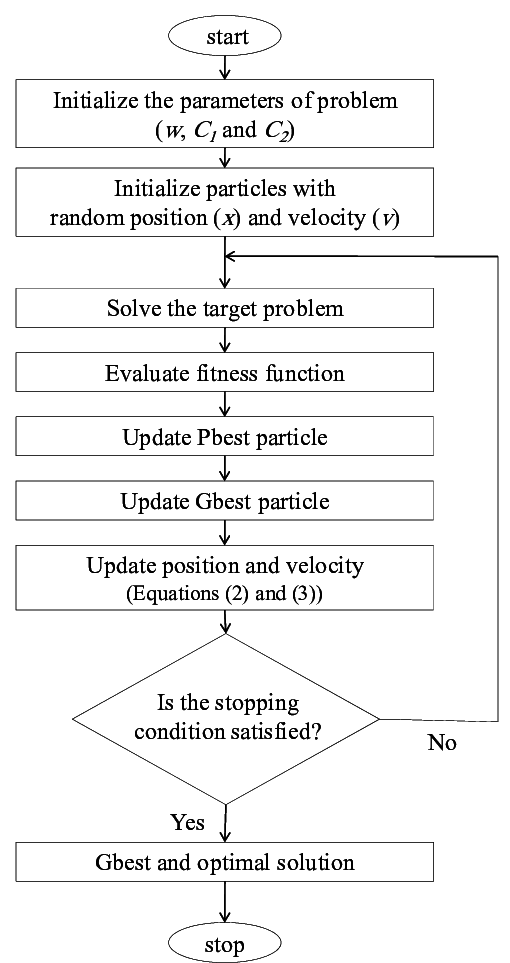

# Objective Function

In [28]:
X=featuredata[['EMA','MACD','RSI','WillR','Slowk','Slowd','ROC','TRIX','SAR','CCI','ATR','ADX']]
y=featuredata["direction"]

In [29]:
X=pd.DataFrame(data=Scaler(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

In [30]:
import random
import time
import matplotlib.pyplot as plt
# ------------------------------------------------------------------------------
def objective_function(O):
    a = int(O[0])
    b = float(O[1])
    RFC=svm.SVC(C = a, gamma = b)
    RFC.fit(X_train,y_train)
    predictions=RFC.predict(X_test)    
    z = accuracy_score(y_test,predictions)
    return z
 


# PSO CODE

In [31]:
class Particle:
    def __init__(self, bounds):
        self.particle_position = []  # particle position
        self.particle_velocity = []  # particle velocity
        self.local_best_particle_position = []  # best position of the particle
        self.fitness_local_best_particle_position = initial_fitness  # initial objective function value of the best particle position
        self.fitness_particle_position = initial_fitness  # objective function value of the particle position
 
        for i in range(nv):
            self.particle_position.append(
                random.uniform(bounds[i][0], bounds[i][1]))  # generate random initial position
            self.particle_velocity.append(random.uniform(-1, 1))  # generate random initial velocity
 
    def evaluate(self, objective_function):
        self.fitness_particle_position = objective_function(self.particle_position)
        if mm == -1:
            if self.fitness_particle_position < self.fitness_local_best_particle_position:
                self.local_best_particle_position = self.particle_position  # update the local best
                self.fitness_local_best_particle_position = self.fitness_particle_position  # update the fitness of the local best
        if mm == 1:
            if self.fitness_particle_position > self.fitness_local_best_particle_position:
                self.local_best_particle_position = self.particle_position  # update the local best
                self.fitness_local_best_particle_position = self.fitness_particle_position  # update the fitness of the local best
 
    def update_velocity(self, global_best_particle_position):
        for i in range(nv):
            r1 = random.random()
            r2 = random.random()
 
            cognitive_velocity = c1 * r1 * (self.local_best_particle_position[i] - self.particle_position[i])
            social_velocity = c2 * r2 * (global_best_particle_position[i] - self.particle_position[i])
            self.particle_velocity[i] = w * self.particle_velocity[i] + cognitive_velocity + social_velocity
 
    def update_position(self, bounds):
        for i in range(nv):
            self.particle_position[i] = self.particle_position[i] + self.particle_velocity[i]
 
            # check and repair to satisfy the upper bounds
            if self.particle_position[i] > bounds[i][1]:
                self.particle_position[i] = bounds[i][1]
            # check and repair to satisfy the lower bounds
            if self.particle_position[i] < bounds[i][0]:
                self.particle_position[i] = bounds[i][0]
 
class PSO:
    def __init__(self, objective_function, bounds, particle_size, iterations):
        fitness_global_best_particle_position = initial_fitness
        global_best_particle_position = []
        swarm_particle = []
        for i in range(particle_size):
            swarm_particle.append(Particle(bounds))
        A = []
 
        for i in range(iterations):
            for j in range(particle_size):
                swarm_particle[j].evaluate(objective_function)
 
                if mm == -1:
                    if swarm_particle[j].fitness_particle_position < fitness_global_best_particle_position:
                        global_best_particle_position = list(swarm_particle[j].particle_position)
                        fitness_global_best_particle_position = float(swarm_particle[j].fitness_particle_position)
                if mm == 1:
                    if swarm_particle[j].fitness_particle_position > fitness_global_best_particle_position:
                        global_best_particle_position = list(swarm_particle[j].particle_position)
                        fitness_global_best_particle_position = float(swarm_particle[j].fitness_particle_position)
            for j in range(particle_size):
                swarm_particle[j].update_velocity(global_best_particle_position)
                swarm_particle[j].update_position(bounds)
 
            A.append(fitness_global_best_particle_position)  # record the best fitness
            # Visualization
            ax.plot(A, color='r')
            fig.canvas.draw()
            ax.set_xlim(left=max(0, i - iterations), right=i + 3)
            time.sleep(0.001)
        print('RESULT:')
        print('Optimal solution:', global_best_particle_position)
        print('Objective function value:', fitness_global_best_particle_position)
# ------------------------------------------------------------------------------
if mm == -1:
    initial_fitness = float("inf")  # for minimization problem
if mm == 1:
    initial_fitness = -float("inf")  # for maximization problem
# ------------------------------------------------------------------------------
# Main PSO
PSO(objective_function, bounds, particle_size, iterations)
plt.show()

RESULT:
Optimal solution: [50, 2]
Objective function value: 0.5405405405405406


C:\Users\Acer\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Objective function')

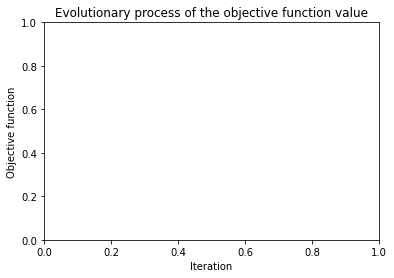

In [32]:
bounds = [(1,1000),(0,1)]  # upper and lower bounds of variables[(Xmin,Xmax),(Ymin,ymax)]
nv = 2  # number of variables
mm = 1  # if minimization problem, mm = -1; if maximization problem, mm = 1
 
# PARAMETERS OF PSO
particle_size = 120  # number of particles
iterations = 200  # max number of iterations
w = 0.8  # inertia constant
c1 = 1  # cognative constant
c2 = 2  # social constant
 
# Visualization
fig = plt.figure()
ax = fig.add_subplot()
fig.show()
plt.title('Evolutionary process of the objective function value')
plt.xlabel("Iteration")
plt.ylabel("Objective function")